# XGBClassifier

## Estado Planctónico Vs biofilm de Cepas de *S. aureus* [BAA-44, ATCC 29213 y ATCC 43300] Extración de Proteínas [AF:ACN] ##

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Etracción 1 #

In [39]:
import glob
fn = []
all_MS = pd.DataFrame()
#nombres=['MF']
for f in glob.glob("C:/Users/Usuario/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Analisis_Datos_Quimica-main/Datos plan B/29213-43300/Extracción 1/*.txt"):
    df = pd.read_csv(f, header=None, delimiter=' ' )
    all_MS = pd.concat([all_MS, df], axis=1)
    fn.append(f) # Guardamos parte del nombre del archivo como una etiqueta de cada muestra
Datamz = all_MS[0] # realciones m/z
Data = all_MS[1] # Intensidades

In [40]:
DataIn=Data[0:20480]
DataIn.columns=range(DataIn.shape[1])
DataMz=Datamz[0:20480]
DataMz.columns=range(DataMz.shape[1])

In [41]:
EtPlanct = pd.read_excel('C:/Users/Usuario/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Analisis_Datos_Quimica-main/Datos plan B/29213-43300/Extracción 1/Etiquetas.xlsx', sheet_name=0, header=None)

Y=EtPlanct[[2]]
Y1=pd.DataFrame(Y.set_axis(axis=1, labels=['Estado']))

### Análisis de Componentes Principales ###

In [42]:
from sklearn.preprocessing import StandardScaler, Normalizer
scaler=StandardScaler()
scaler.fit(DataIn) # calculo la media para poder hacer la transformacion
x_scaled=scaler.transform(DataIn)# Ahora si, escalo los datos y los normalizo

pca=PCA(n_components=10) # Otra opción es hacer pca hasta obtener un mínimo explicado ej.: pca=PCA(.85)
pca1=pca.fit(x_scaled.T) # obtener los componentes principales
datos_pca=pca.transform(x_scaled.T) # convertimos nuestros datos con las nuevas dimensiones de PCA, scores

#out = pca.fit_transform(valtn) # otra opción

# Esta celda es para observar la varianza explicada con 5 componentes, se podría variar a los que se quisiese
print("shape of datos_pca", datos_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:10]))
#Vemos que con 5 componentes tenemos algo mas del 85% de varianza explicada
datos_pca1=pd.DataFrame(datos_pca) # Convierte los datos pca en un DataFrame
datos_pca1=pd.concat([Y1, datos_pca1] ,axis=1) # Se agrega la columna del tipo de muestra

shape of datos_pca (40, 10)
[0.55587292 0.1309026  0.07498316 0.05933636 0.04250251 0.02570415
 0.01996444 0.01850123 0.01352907 0.01165986]
suma: 0.9529563070794014


In [31]:
scores_df = pd.DataFrame(datos_pca, columns = [f"PC{i+1}" for i in range(datos_pca.shape[1])])
scores_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-43.760700,-13.261182,22.522263,-17.386749,8.015201,0.371894,1.578005,-3.499897,-6.546455,-2.033958
1,-44.541320,-15.086721,19.075000,-14.340618,5.743592,0.099351,-0.683323,-1.253552,-8.903057,-1.990692
2,-42.121688,-9.274356,33.307586,-20.937860,7.142367,0.858802,0.353943,1.560630,-1.994912,-0.225004
3,-44.284669,-18.206642,-7.523964,-0.133762,2.204155,-0.521508,3.927062,-8.338901,-4.969335,-2.598797
4,-41.274648,-3.229088,-18.496507,12.551598,-5.498788,1.586843,-5.072504,6.974345,12.269577,4.361850


In [43]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OrdinalEncoder()
encoder.fit(Y1[['Estado']])
Y1_code = encoder.transform (Y1[['Estado']])
Y1_code = pd.DataFrame(Y1_code)

In [44]:
Y1_code.shape

(40, 1)

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

modeloXGB = XGBClassifier(random_state=123)
kf = KFold(n_splits=4, shuffle=True, random_state=123)

puntuaciones = cross_val_score(modeloXGB, x_scaled.T, Y1_code.values.ravel(), cv=kf, scoring='f1')

# Imprime las puntuaciones obtenidas en cada fold
print("Puntuaciones de cada fold:", puntuaciones)

# Imprime la puntuación media y su desviación estándar
print("Puntuación media:", np.mean(puntuaciones))
print("Desviación estándar de las puntuaciones:", np.std(puntuaciones))


Puntuaciones de cada fold: [0.66666667 0.5        0.5        0.72727273]
Puntuación media: 0.5984848484848484
Desviación estándar de las puntuaciones: 0.10078889920947019


In [36]:
# Ahora, puedes obtener el reporte de clasificación promediado sobre los folds
y_pred_cv = cross_val_predict(modeloXGB, x_scaled.T, Y1_code.values.ravel(), cv=kf)
Matriz = confusion_matrix(Y1_code, y_pred_cv)
Reporte = classification_report(Y1_code, y_pred_cv)

print(Matriz)
print(Reporte)

[[22  3]
 [ 7  8]]
              precision    recall  f1-score   support

         0.0       0.76      0.88      0.81        25
         1.0       0.73      0.53      0.62        15

    accuracy                           0.75        40
   macro avg       0.74      0.71      0.72        40
weighted avg       0.75      0.75      0.74        40



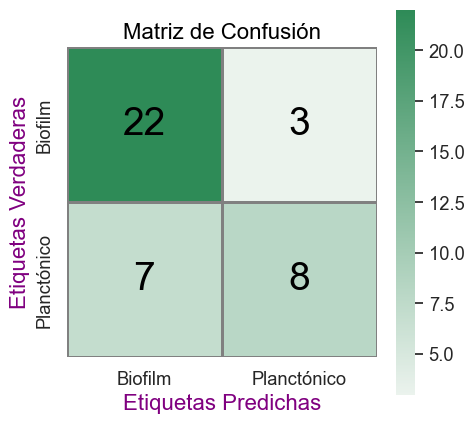

In [37]:
# Colores personalizados
cmap = sns.light_palette("seagreen", as_cmap=True)

# Crea un mapa de calor (heatmap) con Seaborn
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente

# Ajusta el tamaño de fuente y otros atributos de texto dentro de la matriz
annot_kws = {"size": 28, "color": "black"}

sns.heatmap(Matriz, annot=True, fmt='d', cmap=cmap, cbar=True, square=True,
            xticklabels=['Biofilm', 'Planctónico'],
            yticklabels=['Biofilm', 'Planctónico'], linewidths=1, linecolor='gray',
            annot_kws=annot_kws)  # Aplica las configuraciones de annot_kws

plt.xlabel('Etiquetas Predichas', fontsize=16, color='purple')
plt.ylabel('Etiquetas Verdaderas', fontsize=16, color='purple')
plt.title('Matriz de Confusión', fontsize=16, color='black')
plt.savefig('Matriz XGB1', dpi=300)

plt.show()